In [1]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt

from champ_optics_Model import MCMC_Model,get_mean_err

from glob import glob
from pathlib import PurePath,Path

c:\Users\xiaod\.conda\envs\CCATholo\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
##inputs
Data_folder='./4_30/test_1_95m/find_focus/'
keywords='D_1_95m_*'
outputfolder='./Results/1_95m/'

In [3]:
def plot_meas(data_List,data_f_List):
    fig = plt.figure(figsize=(12,10))
    for idx, data in enumerate(data_List):
        x = data[:,0]
        plt.subplot(211)
        plt.plot(
            x,
            data[:,1],
            '*-',
            label=f"{data_f_List[idx].split('/')[-1]}"
        )
        plt.legend(fontsize=5)
        plt.xlabel(r'$\Delta z$ [mm]')

        plt.subplot(212)
        freq = fft.fftshift(
            fft.fftfreq(
                data.shape[0],
                np.diff(x).mean()
            )
        )
        delta_x = np.diff(x).mean()
        spectrum = fft.fftshift(fft.fft(data[:,1])) / (freq.size)
        plt.plot(
            1./freq,
            np.abs(spectrum),'*-',
            label=f"{data_f_List[idx].split('/')[-1]}"
        )
        plt.xscale('log')
        plt.yscale('log')
        plt.legend(fontsize=12)
        
        plt.xlabel(r'$\lambda \ [\mathrm{mm}]$')
    plt.subplot(211)
    plt.grid(which='both', axis='both')
    plt.subplot(212)
    plt.grid(which='both', axis='both')
    plt.tight_layout()

def get_samples(data_List):
    data_samples=np.zeros([data_List[0].shape[0],len(data_List)])
    for idx, data in enumerate(data_List):
        data_samples[:,idx] = data[:,1]
    x_vec=data_List[0][:,0]

    data_samples_zp = data_samples.copy()
    freq_vec = fft.fftshift(
        fft.fftfreq(
            data_samples_zp.shape[0], 
            np.diff(x_vec).mean()
            )
        )
    spec_samp = fft.fftshift(
        fft.fft(data_samples_zp, axis=0) / (len(freq_vec) // 2)
        )
    
    return x_vec, data_samples, freq_vec, spec_samp
    
def plot_correct(x_vec,samples,f_vec,spec):
    fig = plt.figure(figsize=(12,10))
    plt.subplot(311)
    samples=samples-samples.mean(axis=0)
    mean,err = get_mean_err(samples)
    spec_mean,spec_err = get_mean_err(np.abs(spec))
    plt.errorbar(
        x_vec,
        mean,
        yerr=err,
        marker='.', ls='--', color=f'gray',
        label=f"all data",
        capsize=3, markeredgewidth=2,
        fillstyle='none'
    )
    plt.grid(which='both', axis='both')
    plt.legend()
    plt.xlabel(r'$\Delta z$ [mm]')

    plt.subplot(312)
    plt.errorbar(
        1./f_vec,
        spec_mean,
        yerr=spec_err,
        marker='.', ls='--', color=f'gray',
        label=f"all data",
        capsize=3, markeredgewidth=2,
        fillstyle='none'
    )
    plt.xscale('log')
    plt.yscale('log')

    plt.grid(which='both', axis='both')
    plt.legend()
    plt.xlabel(r'$\lambda \ [\mathrm{mm}]$')

    plt.subplot(313)
    plt.errorbar(
        f_vec,
        spec_mean,
        yerr=spec_err,
        marker='.', ls='--', color=f'gray',
        label=f"all data",
        capsize=3, markeredgewidth=2,
        fillstyle='none'
    )
    # plt.xscale('log')
    plt.yscale('log')

    plt.grid(which='both', axis='both')
    plt.legend()
    plt.xlabel(r'$k \ [\mathrm{mm}^{-1}]$')
    plt.tight_layout()
    

### 1. Analysis 1.95m separation distance

C:\Users\xiaod\AppData\Local\Temp\ipykernel_10040\2704952921.py:25: RuntimeWarning: divide by zero encountered in divide
  1./freq,
C:\Users\xiaod\AppData\Local\Temp\ipykernel_10040\2704952921.py:80: RuntimeWarning: divide by zero encountered in divide
  1./f_vec,


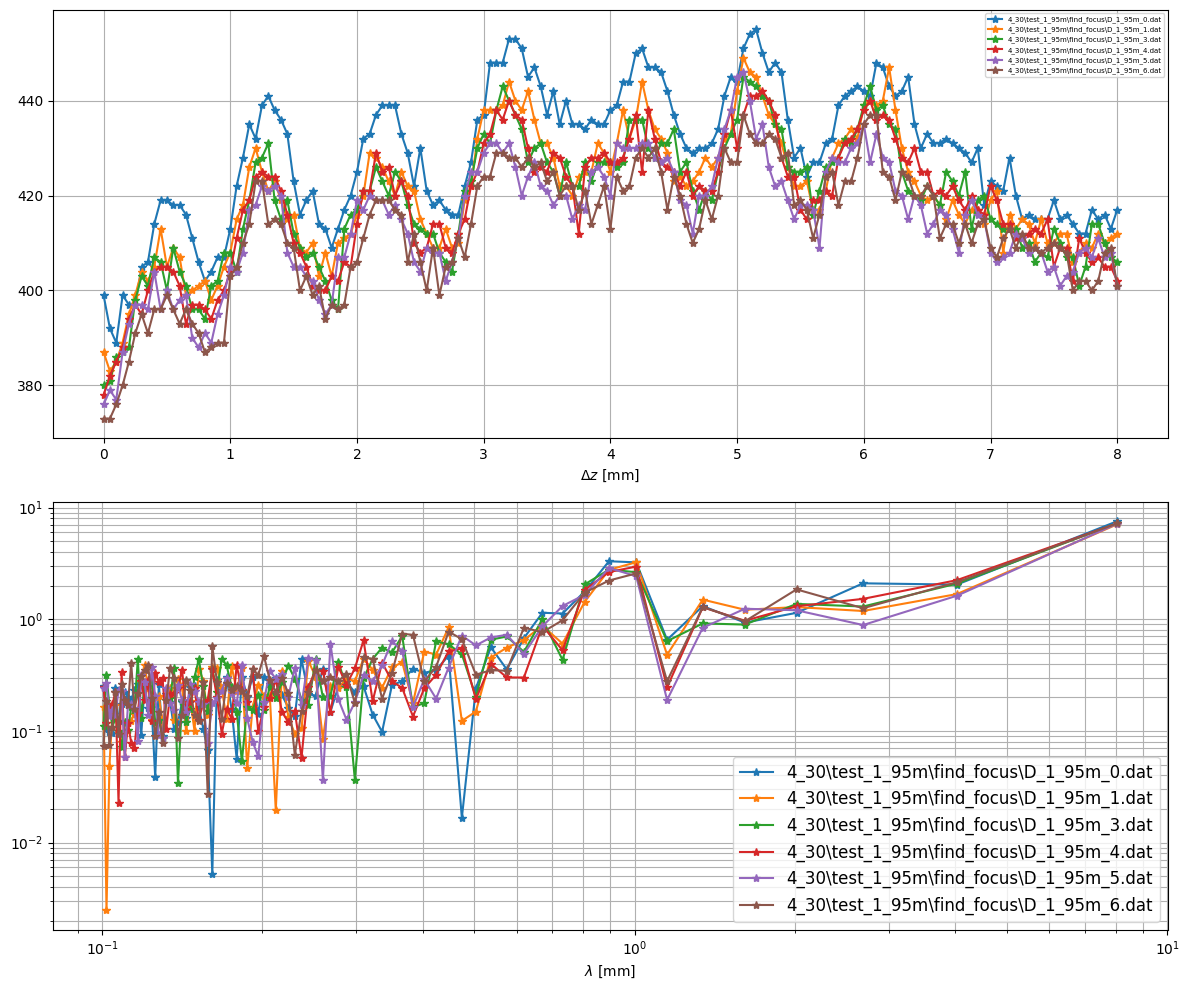

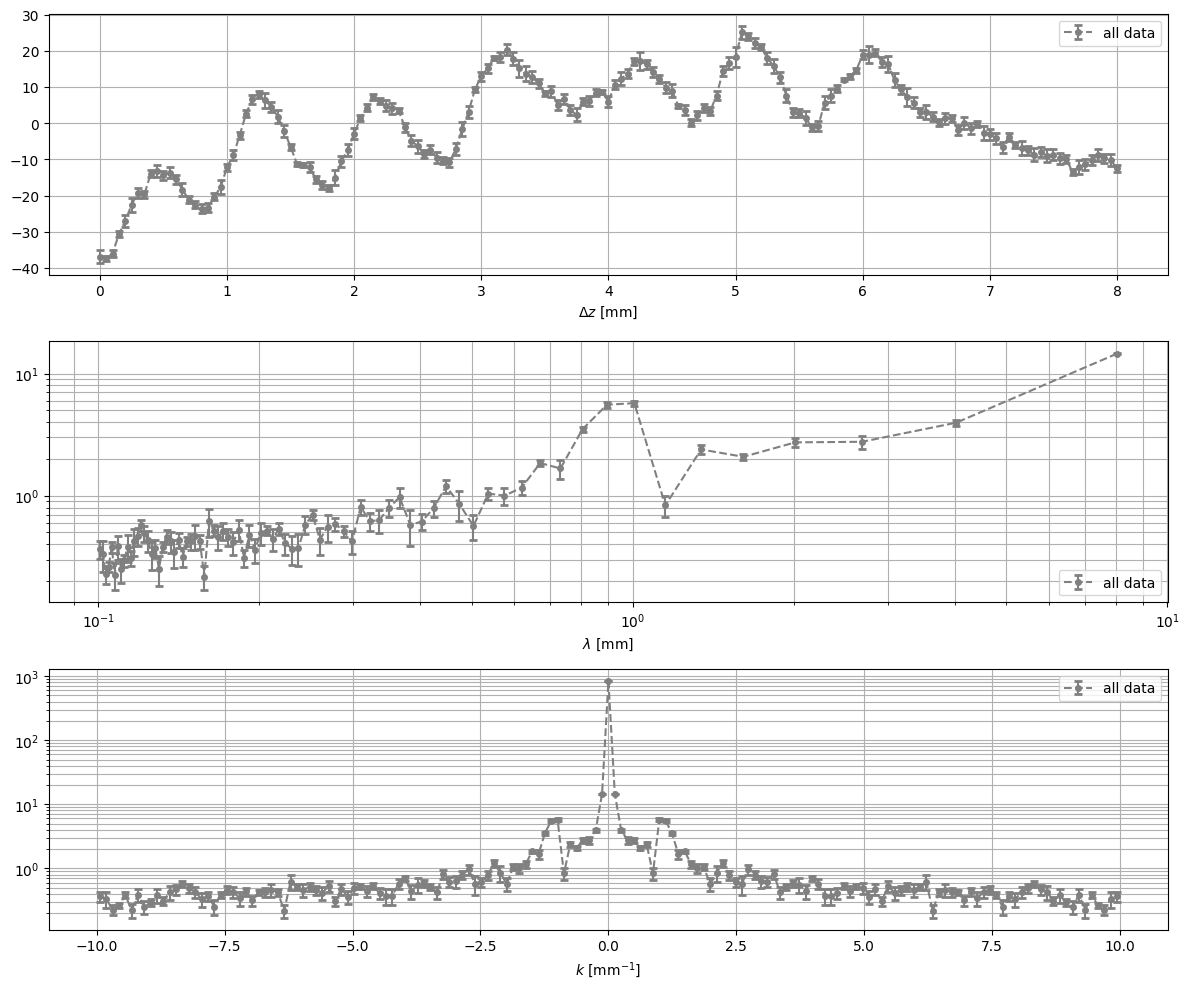

In [4]:
# 1. read data
D_folder=PurePath(Data_folder)
data_file_list = sorted(glob(str(D_folder / keywords)))
data_list1 = [
    np.genfromtxt(data_file) for data_file in data_file_list
]
# 2. plot and analysis its spectrum
plot_meas(data_list1,data_file_list)
z_vec, data_samples1, freq_vec, Spec_samples1 = get_samples(data_list1)
plot_correct(z_vec, data_samples1, freq_vec, Spec_samples1)



#### 3. Run McMc
**3.1. parabolic model

In [5]:
# 3. ran mcmc
# 1. parabolic model
n_walkers = 50

"""Model 1 2nd polynomial model"""
bounds_0 = np.asarray(
    [
        [-8, 0],
        [2, 17],
        [0,100]
    ]
)
Model_2nd = MCMC_Model(
    z_vec, data_samples1, 
    2, 0, 
    bounds_0,
    "2nd poly"
)

corr_time = Model_2nd.sample(
    np.array([-0.005,5,1]),
    n_walkers,
    10000,
    filename=outputfolder+'parab_mcmc_analy.h5'
)


  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\xiaod\.conda\envs\CCATholo\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [01:43<00:00, 96.45it/s]


(17750, 3)


e:\E_Laptop_new\Project in Köln\1_Holography inference\CCAT-Documents\HOLO-Ref Rx\optics for CHAI\Fore-optics_Test\champ_optics_Model.py:263: RuntimeWarning: divide by zero encountered in divide
  1./freq,


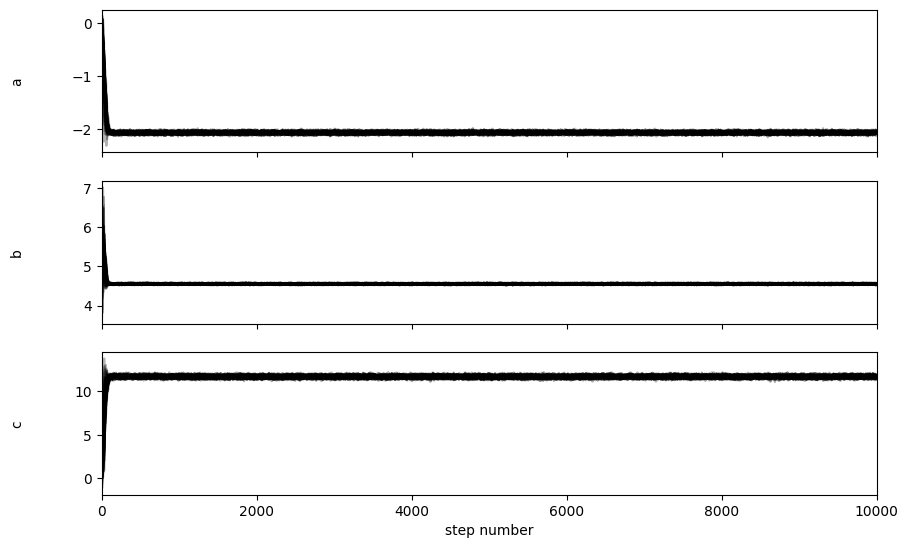

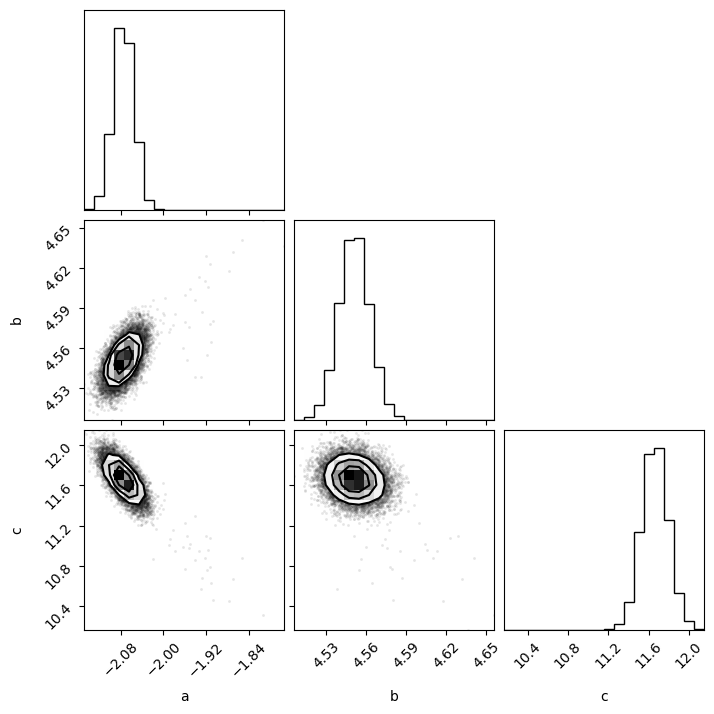

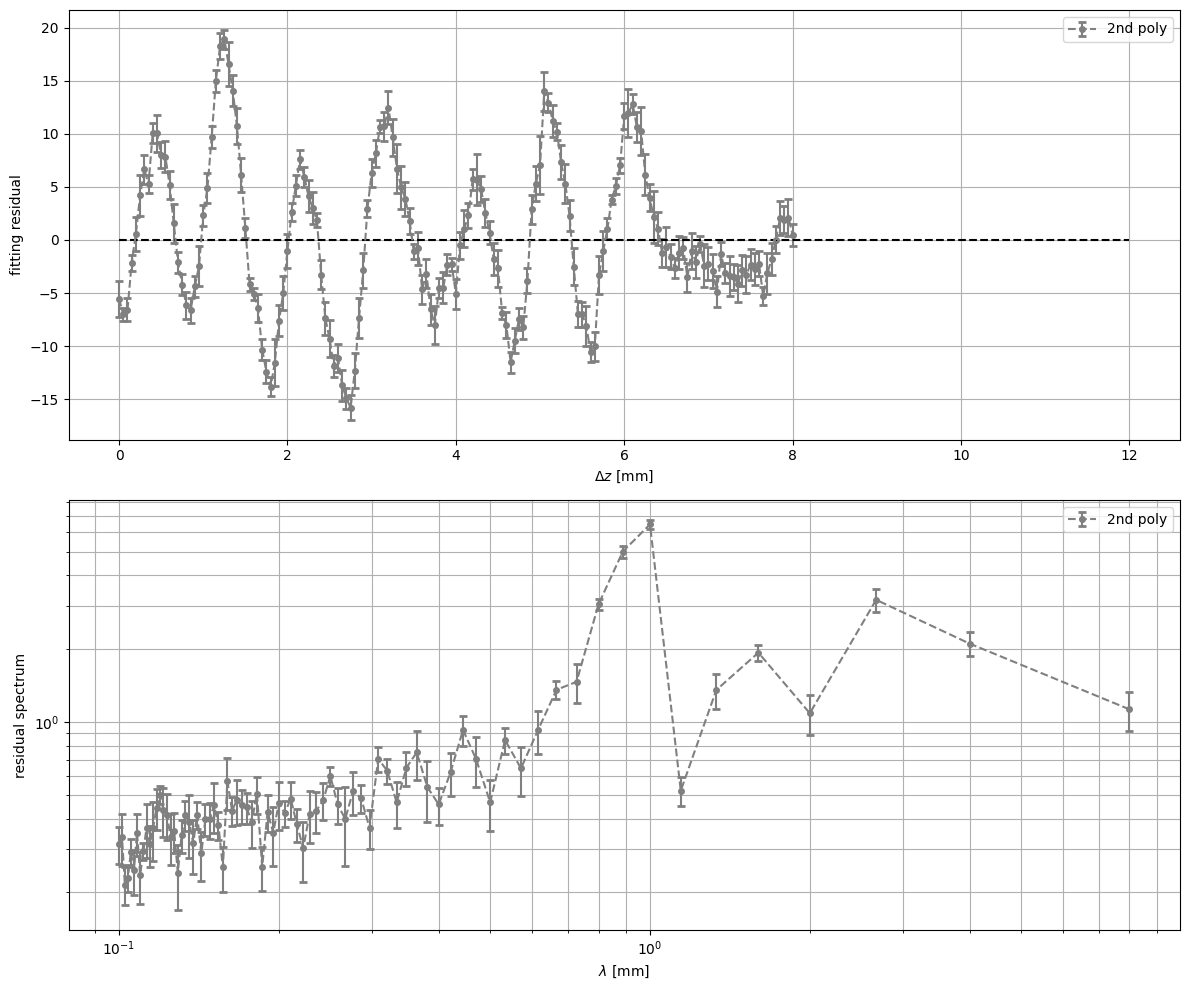

In [7]:
_ = Model_2nd.plot_chain()
_ = Model_2nd.plot_corner(
    discard=2*int(corr_time.max()//2),
    thin=int(corr_time.max()//2)    
)
_ = Model_2nd.plot_residual()

In [25]:
"""Model 1 2nd polynomial model + 1sw"""
n_walkers = 50
bounds_0 = np.asarray(
    [
        [-4, -1],
        [3, 6],
        [9,18],
        [2,10],
        [0.9,0.975],
        [-np.pi,np.pi]
    ]
)
Model_2nd_1sw = MCMC_Model(
    z_vec, data_samples1, 
    2, 1, 
    bounds_0,
    "2nd poly + 1sw"
)

corr_time = Model_2nd_1sw.sample(
    np.array([-1.11,5.0,14.5,3.5,0.95,-1]),
    n_walkers,
    20000,
    filename=outputfolder+'parab_1sw_mcmc_analy.h5'
)
print(corr_time)



  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [03:38<00:00, 91.61it/s]


[ 44.53239956  66.49786831  77.5402737  103.6510822   63.8588421
  72.85679551]


(19400, 6)


e:\E_Laptop_new\Project in Köln\1_Holography inference\CCAT-Documents\HOLO-Ref Rx\optics for CHAI\Fore-optics_Test\champ_optics_Model.py:263: RuntimeWarning: divide by zero encountered in divide
  1./freq,


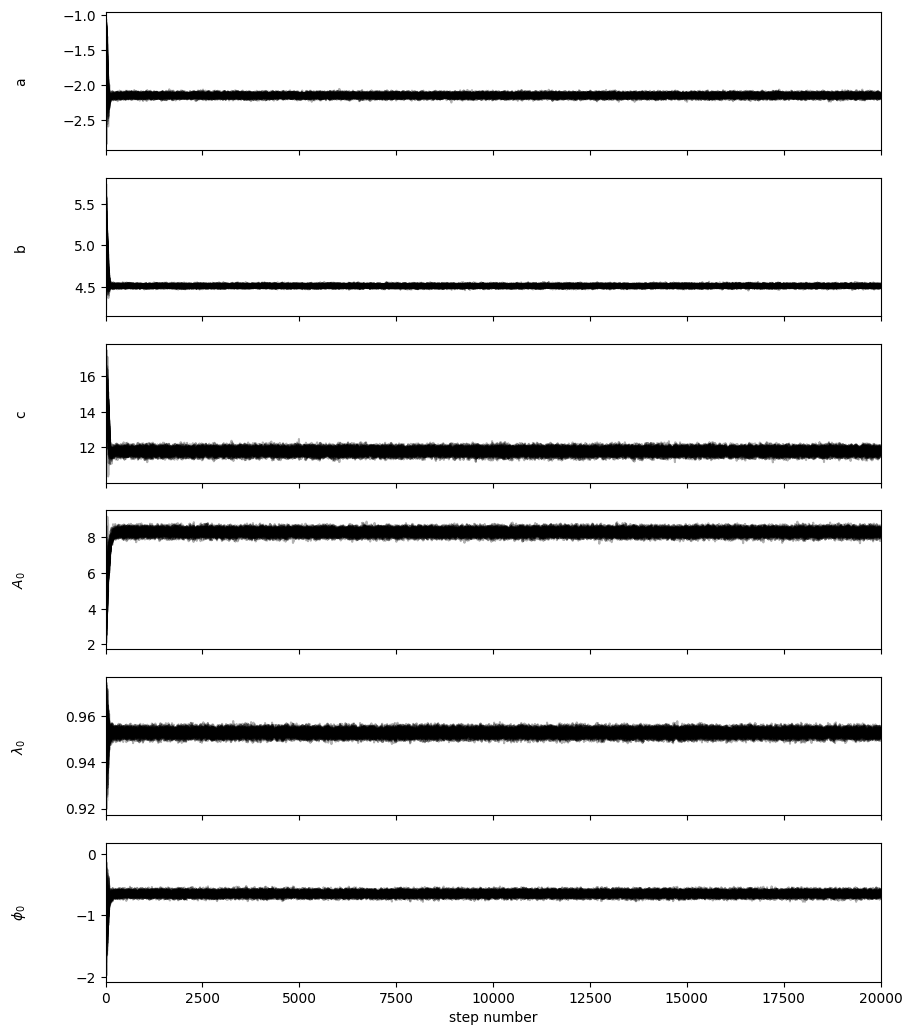

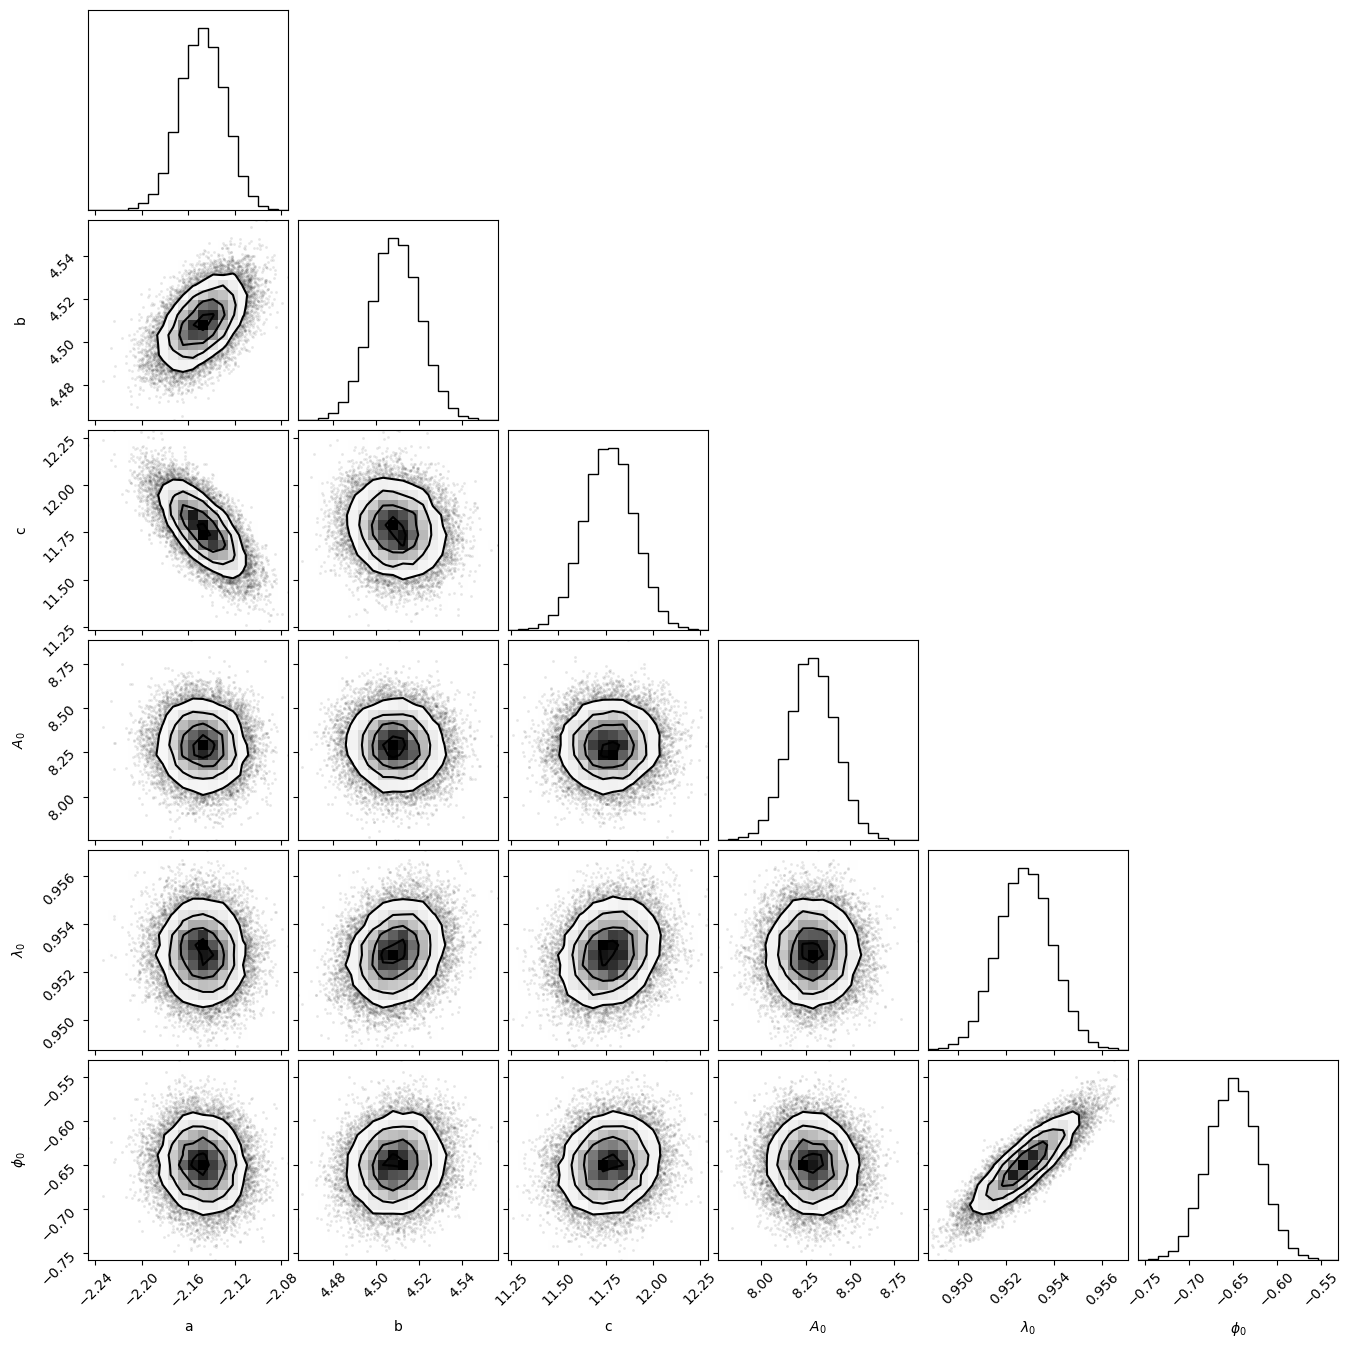

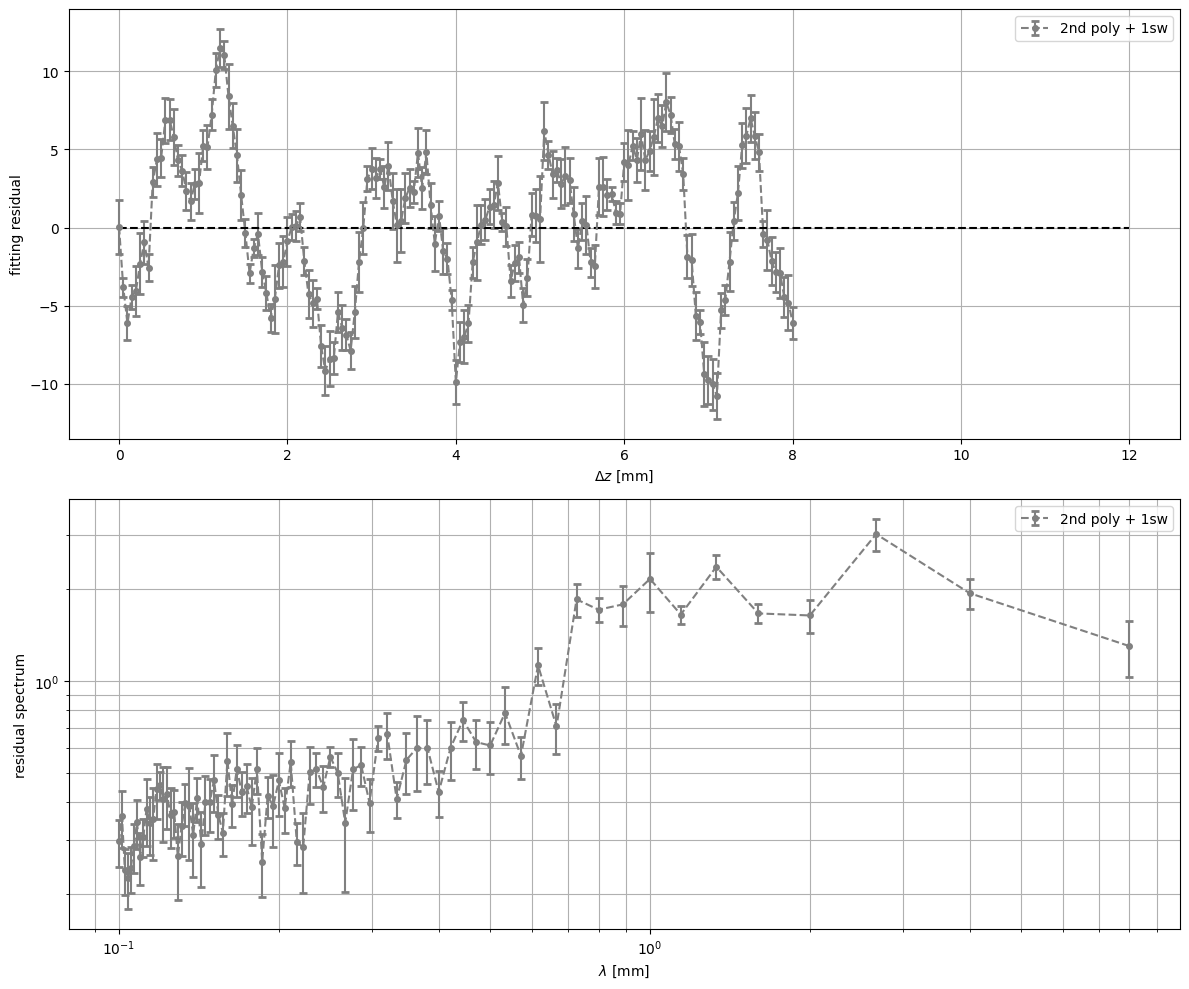

In [26]:
_ = Model_2nd_1sw.plot_chain()
_ = Model_2nd_1sw.plot_corner(
    discard = 2*int(corr_time.max()),
    thin = int(corr_time.max()//2),
)
_ = Model_2nd_1sw.plot_residual()


In [54]:
"""Model 1 2nd polynomial model + 2sw"""
bounds_0 = np.asarray(
    [
        [-4, -1],
        [3, 6],
        [9,18],
        [2,10],
        [0.95,0.9999],
        [-np.pi,np.pi],
        [0,10],
        [2.2,3],
        [-np.pi,np.pi],
    ]
)
Model_2nd_2sw = MCMC_Model(
    z_vec, data_samples1, 
    2, 2, 
    bounds_0,
    "2nd poly + 2sw"
)

corr_time = Model_2nd_2sw.sample(
    np.array([-1.2,5,15,3,0.952,-0.6,2,2.5,1]),
    n_walkers,
    50000,
    filename=outputfolder+'parab_2sw_mcmc_analy.h5'
)
print(corr_time)


100%|██████████| 40000/40000 [07:34<00:00, 88.04it/s]


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 800;
tau: [ 295.5279609   460.79464461  337.47580387  275.51137796 2944.6072354
  749.56879375 3268.9860362  1722.00201307 2858.95108436]

(6350, 9)


e:\E_Laptop_new\Project in Köln\1_Holography inference\CCAT-Documents\HOLO-Ref Rx\optics for CHAI\Fore-optics_Test\champ_optics_Model.py:263: RuntimeWarning: divide by zero encountered in divide
  1./freq,


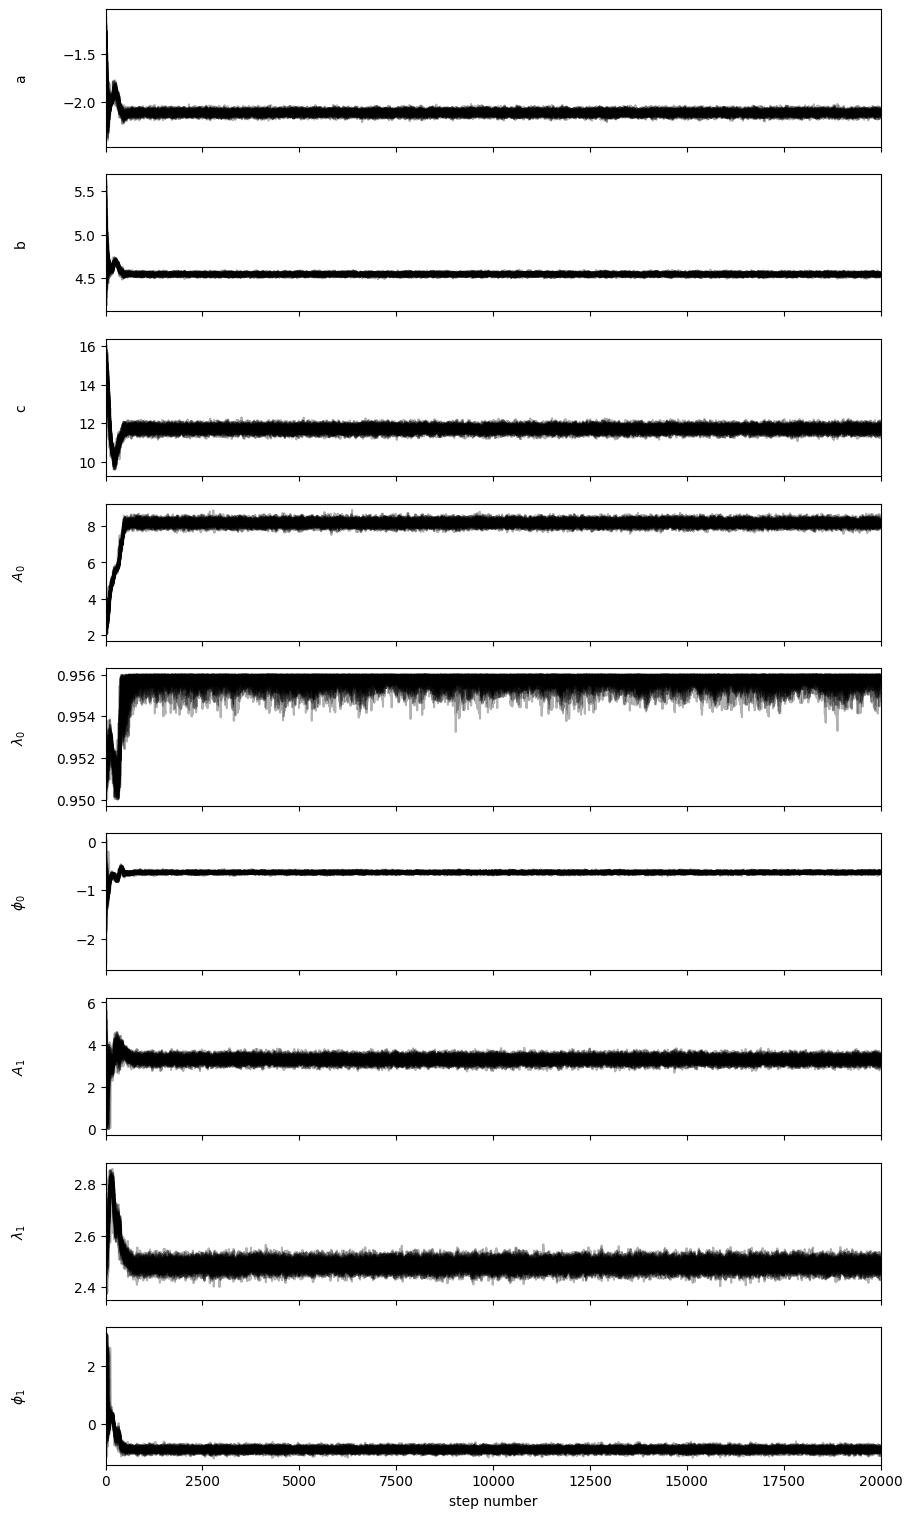

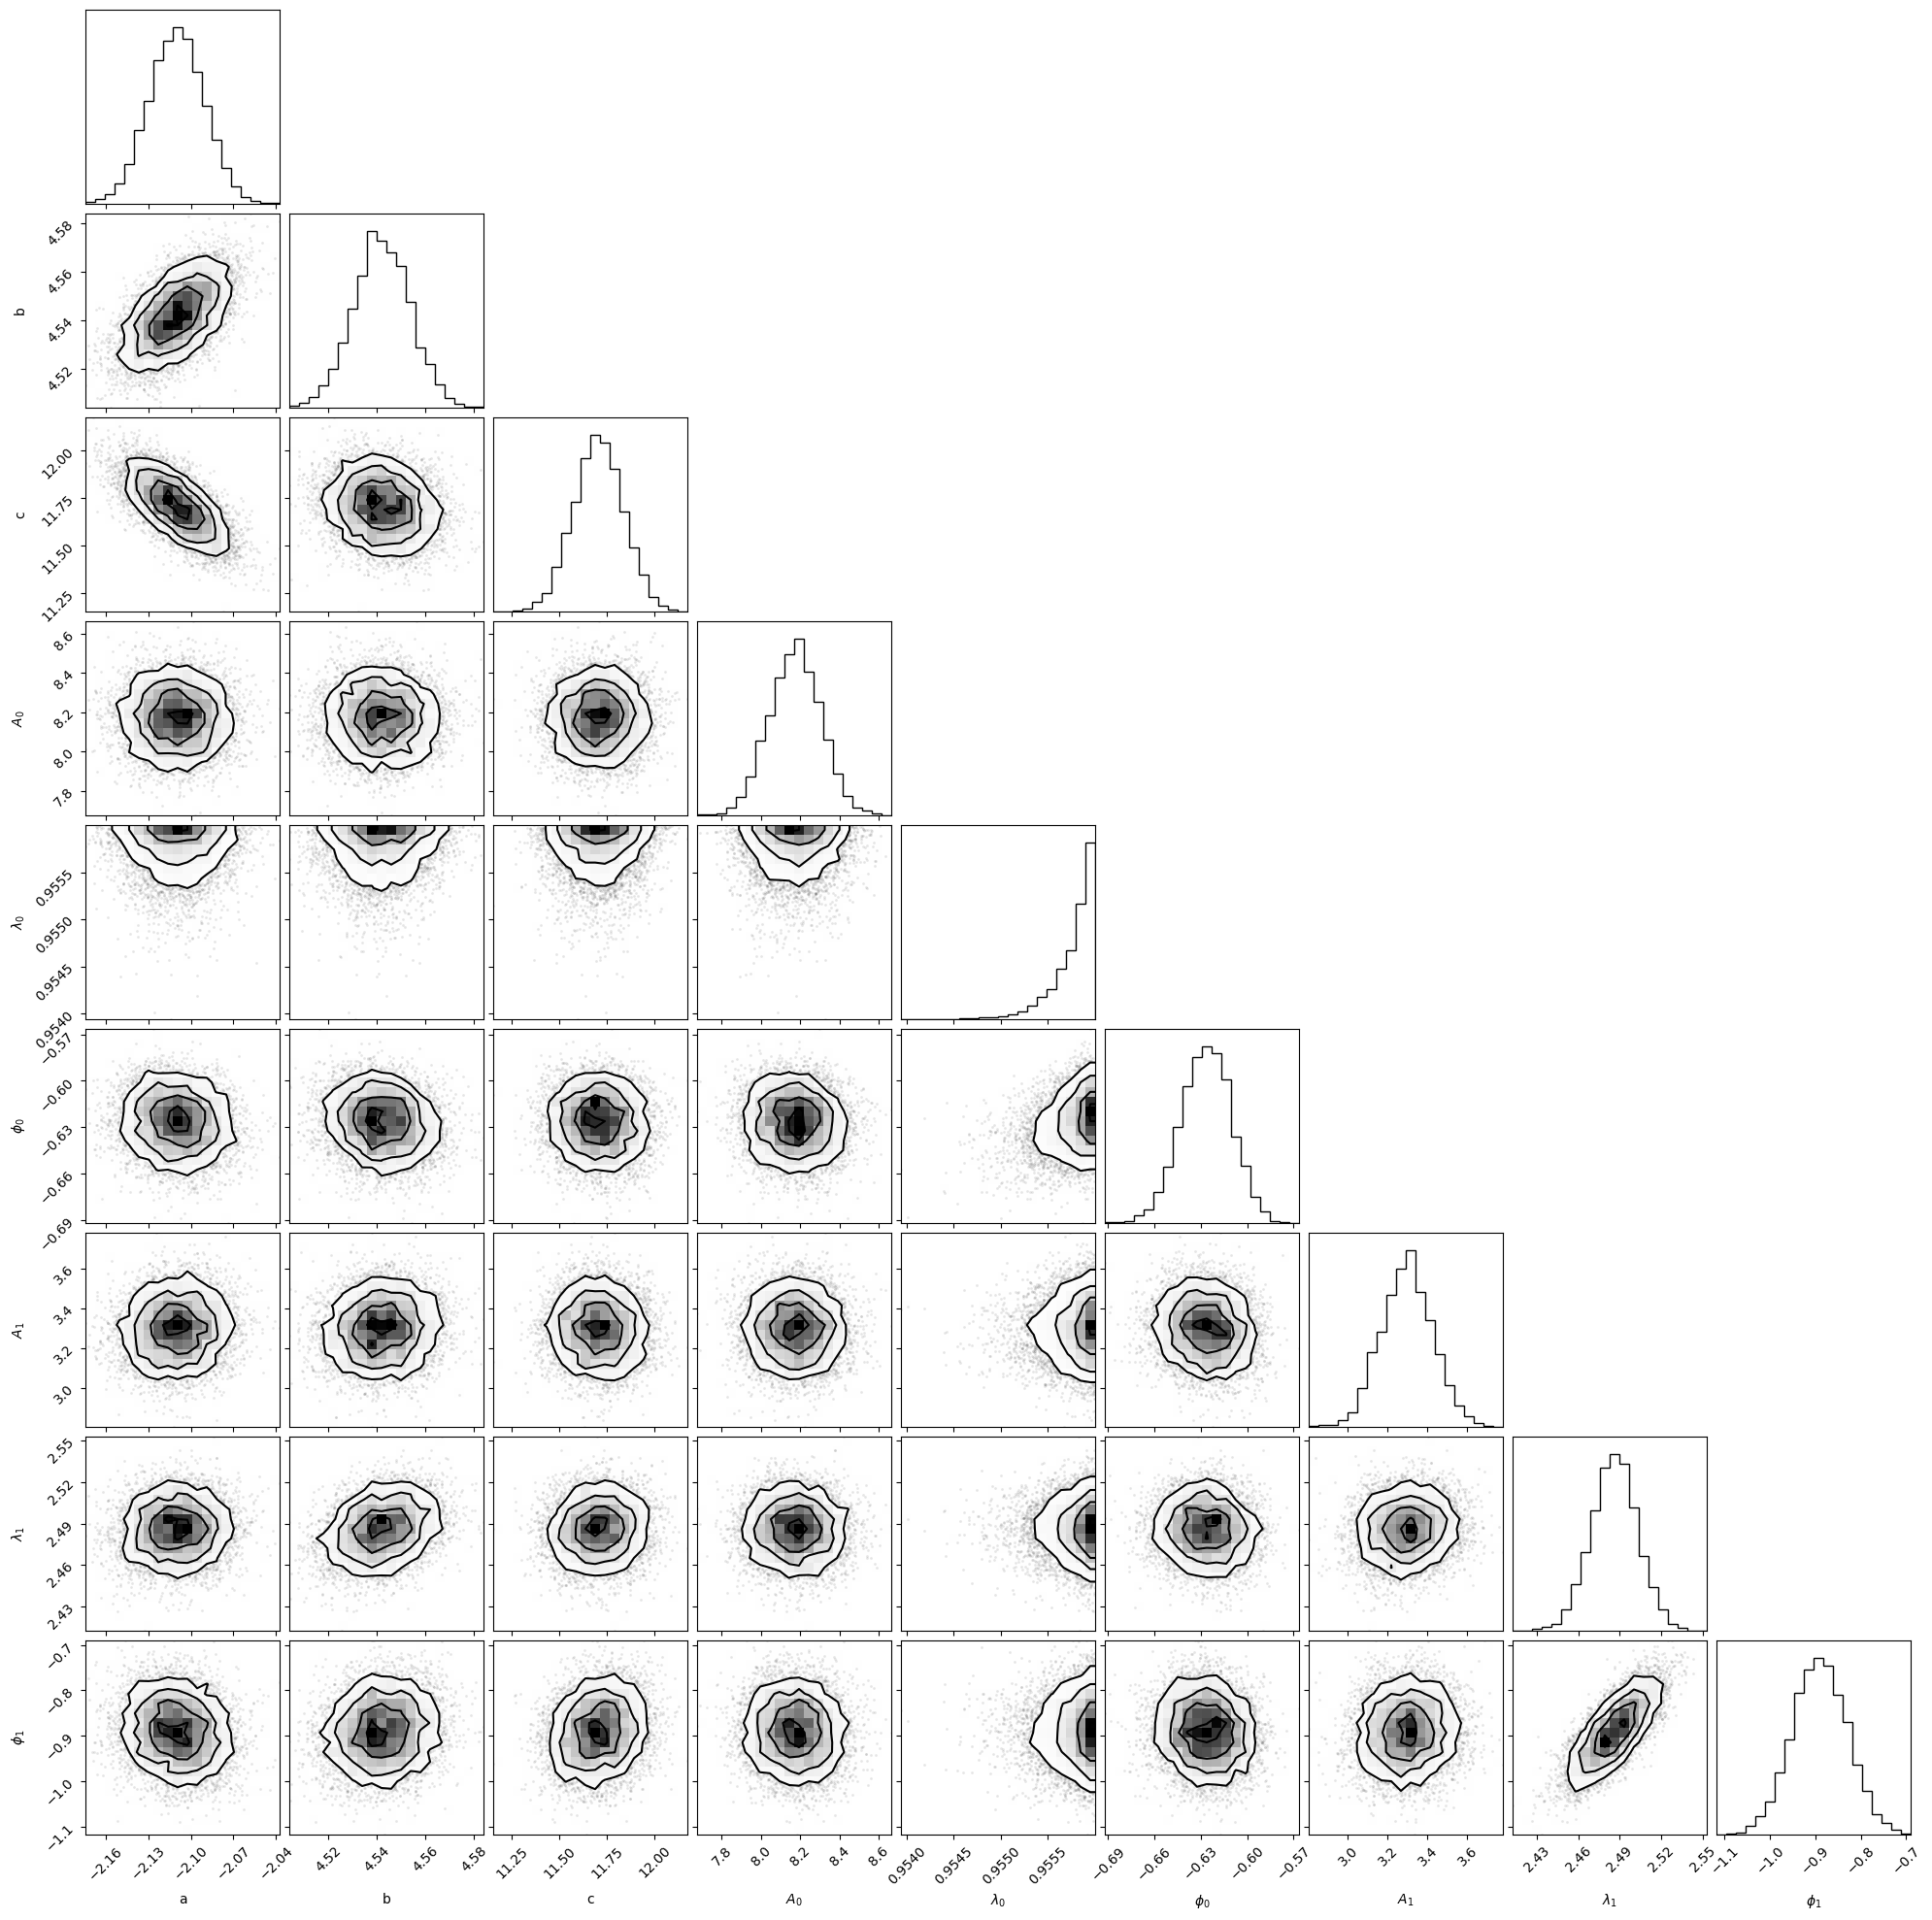

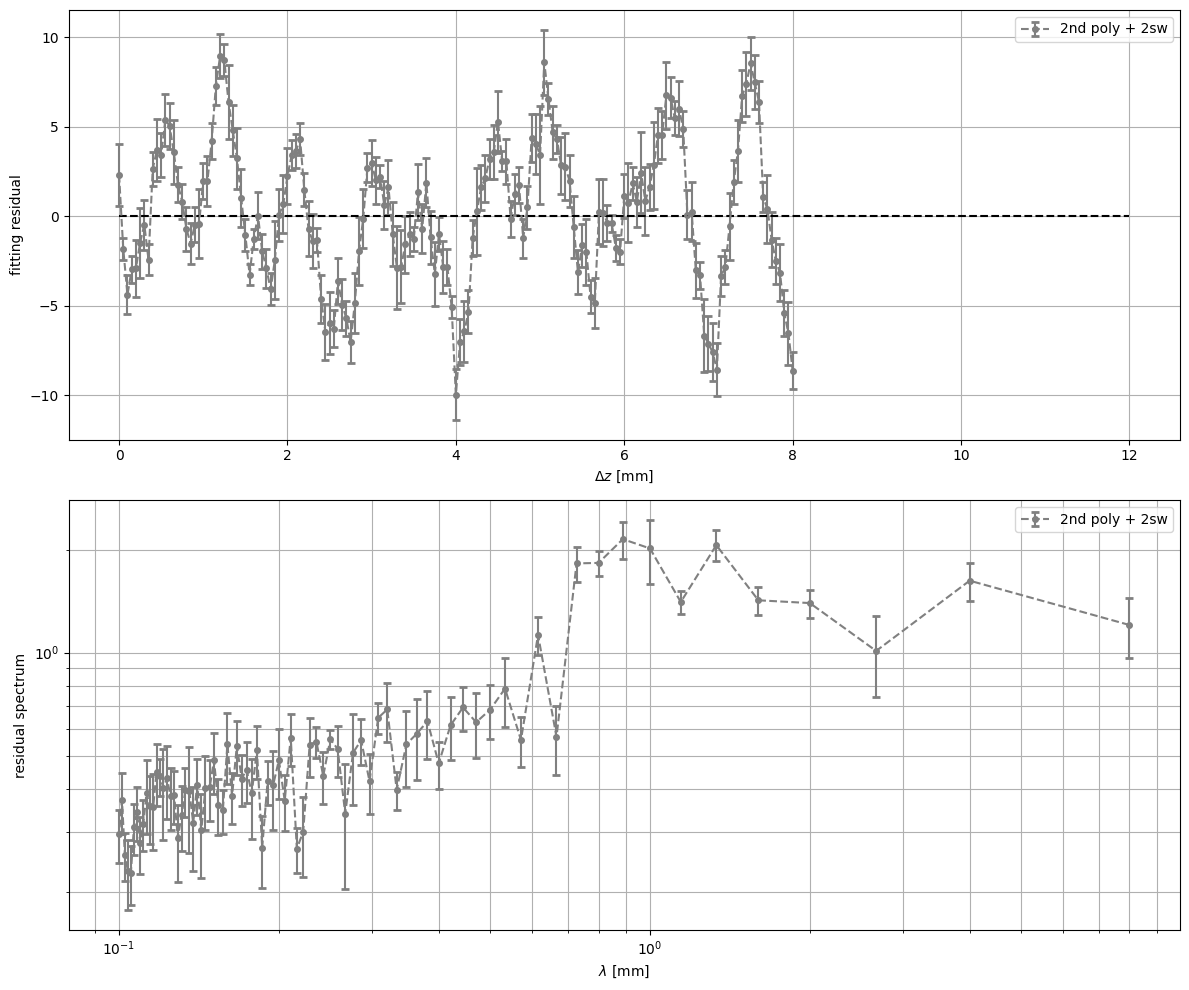

In [53]:
_ = Model_2nd_2sw.plot_chain()
_ = Model_2nd_2sw.plot_corner(
    discard=int(corr_time.max())*2,
    thin=int(corr_time.max()//2),
)

_ = Model_2nd_2sw.plot_residual()

In [ ]:
"""Model 1 2nd polynomial model + 3sw"""
bounds_0 = np.asarray(
    [
        [-4, -1],
        [3, 6],
        [9,18],
        [2,10],
        [0.95,0.956],
        [-np.pi,np.pi],
        [0,10],
        [2,2.1],
        [-np.pi,np.pi],
        [0,4],
        [0.98,1.0],
        [-np.pi,np.pi]
    ]
)
Model_2nd_3sw = MCMC_Model(
    z_vec, data_samples1, 
    2, 3, 
    bounds_0,
    "2nd poly + 3sw"
)
corr_time = Model_2nd_3sw.sample(
    np.array([-1.2,5,15,3,0.92,-0.6,3,0.97,1,3,0.99,1]),
    n_walkers,
    50000,
    filename=outputfolder+'parab_3sw_mcmc_analy.h5'
)

In [ ]:
_ = Model_2nd_3sw.plot_chain()
_ = Model_2nd_3sw.plot_corner(
    discard=int(corr_time.max())*2,
    thin=int(corr_time.max()//2),
)
_ = Model_2nd_3sw.plot_residual()

In [ ]:
# collect model to list
fit_model_list = [
    Model_2nd,
    Model_2nd_1sw,
    Model_2nd_2sw,
    #Model_2nd_3sw,
]

b_bins = np.linspace(4.7, 5.3, 1000)
for idx, fit_model in enumerate(fit_model_list):
    _ = plt.hist(
        fit_model.flat_samples[:,1], bins=b_bins,
        density=True,
        alpha=0.3, color=f'C{idx}',
        label=fit_model.model_label
    )
plt.xlabel("b")
plt.ylabel("hist")
plt.legend()

In [ ]:
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.errorbar(
    Model_2nd.x_vec,
    Model_2nd.y_mean,
    yerr=Model_2nd.y_err,
    marker='.', ls='--', color=f'gray',
    label=f"all data",
    capsize=3, markeredgewidth=2,
    fillstyle='none'
)

for idx, fit_model in enumerate(fit_model_list):
    pred_res = fit_model.model_batch(fit_model.flat_samples)
    model_quantil = np.quantile(
        pred_res,
        [0.05, 0.16, 1-0.16, 1-0.05],
        axis=-1
    )
    plt.fill_between(
        fit_model.x_vec,
        y1=model_quantil[0],
        y2=model_quantil[-1],
        color=f"C{idx}",
        alpha=0.2
    )
    plt.fill_between(
        fit_model.x_vec,
        y1=model_quantil[1],
        y2=model_quantil[-2],
        color=f"C{idx}",
        alpha=0.6
    )
plt.grid(which='both', axis='both')
plt.legend()
plt.xlabel(r'$\Delta z$ [mm]')

plt.subplot(212)
for idx, fit_model in enumerate(fit_model_list):
    param_mean = np.atleast_2d(fit_model.flat_samples.mean(axis=0))
    pred_res = fit_model.model_batch(param_mean)[:,0]
    plt.errorbar(
        fit_model.x_vec,
        fit_model.y_mean-pred_res,
        yerr=fit_model.y_err,
        marker='.', ls='--', color=f'C{idx}',
        label=fit_model.model_label,
        capsize=3, markeredgewidth=2,
        fillstyle='none'
    )
plt.hlines(y=0, xmin=0, xmax=12, color='k', ls='--')
plt.grid(which='both', axis='both')
plt.legend()
plt.xlabel(r'$\Delta z$ [mm]')
plt.ylabel('fitting residual')

plt.tight_layout()


#### 3. Run McMc
**3.2. sine model

In [ ]:
# 3. ran mcmc
# 3.2. sine model
n_walkers = 50

"""Model 1 3rd polynomial model"""
bounds_0 = np.asarray(
    [
        [-100,100],
        [20, 80],
        [10, 50],
        [-np.pi,np.pi],
        
    ]
)
Model_sin = MCMC_Model(
    z_vec, data_samples1, 
    'sin', 1, 
    bounds_0,
    "sin"
)

corr_time = Model_sin.sample(
    np.array([0.0,
              40,
              15,
              0]),
    n_walkers,
    10000,
    filename=outputfolder+'Sine_mcmc_analy.h5'
)

In [ ]:
_ = Model_sin.plot_chain()

_ = Model_sin.plot_corner(
    discard=2*int(corr_time.max()),
    thin=int(corr_time.max()//2),
)
_ = Model_sin.plot_residual()

In [ ]:
# 3. ran mcmc
# 3.2. sine model +1sw
n_walkers = 50

"""Model 1 3rd polynomial model"""
bounds_0 = np.asarray(
    [
        [-20,0],
        [10, 50],
        [10, 30],
        [-np.pi,np.pi],
        [2, 10],
        [0.9, 0.999],
        [-np.pi,np.pi],
        
    ]
)
Model_sin_1sw = MCMC_Model(
    z_vec, data_samples1, 
    'sin', 2, 
    bounds_0,
    "sin + 1sw"
)

corr_time = Model_sin_1sw.sample(
    np.array([-5,23,14,-0.5,
              3,0.91,-1
              ]),
    n_walkers,
    20000,
    filename=outputfolder+'Sine_1sw_mcmc_analy.h5'
)

In [ ]:
_ = Model_sin_1sw.plot_chain()

_ = Model_sin_1sw.plot_corner(
    discard=2*int(corr_time.max()),
    thin=int(corr_time.max()//2),

)
_ = Model_sin_1sw.plot_residual()

In [ ]:
# collect model to list
fit_model_list = [
    Model_sin,
    Model_sin_1sw
]

b_bins = np.linspace(4.7, 5.3, 1000)
for idx, fit_model in enumerate(fit_model_list):
    x0= (np.pi/2-fit_model.flat_samples[:,3])*fit_model.flat_samples[:,2]/(2*np.pi)
    _ = plt.hist(
        x0, bins=b_bins,
        density=True,
        alpha=0.3, color=f'C{idx}',
        label=fit_model.model_label
    )
plt.xlabel("b")
plt.ylabel("hist")
plt.legend()

In [ ]:
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.errorbar(
    Model_2nd.x_vec,
    Model_2nd.y_mean,
    yerr=Model_2nd.y_err,
    marker='.', ls='--', color=f'gray',
    label=f"all data",
    capsize=3, markeredgewidth=2,
    fillstyle='none'
)

for idx, fit_model in enumerate(fit_model_list):
    pred_res = fit_model.model_batch(fit_model.flat_samples)
    model_quantil = np.quantile(
        pred_res,
        [0.05, 0.16, 1-0.16, 1-0.05],
        axis=-1
    )
    plt.fill_between(
        fit_model.x_vec,
        y1=model_quantil[0],
        y2=model_quantil[-1],
        color=f"C{idx}",
        alpha=0.2
    )
    plt.fill_between(
        fit_model.x_vec,
        y1=model_quantil[1],
        y2=model_quantil[-2],
        color=f"C{idx}",
        alpha=0.6
    )
plt.grid(which='both', axis='both')
plt.legend()
plt.xlabel(r'$\Delta z$ [mm]')

plt.subplot(212)
for idx, fit_model in enumerate(fit_model_list):
    param_mean = np.atleast_2d(fit_model.flat_samples.mean(axis=0))
    pred_res = fit_model.model_batch(param_mean)[:,0]
    plt.errorbar(
        fit_model.x_vec,
        fit_model.y_mean-pred_res,
        yerr=fit_model.y_err,
        marker='.', ls='--', color=f'C{idx}',
        label=fit_model.model_label,
        capsize=3, markeredgewidth=2,
        fillstyle='none'
    )
plt.hlines(y=0, xmin=0, xmax=12, color='k', ls='--')
plt.grid(which='both', axis='both')
plt.legend()
plt.xlabel(r'$\Delta z$ [mm]')
plt.ylabel('fitting residual')

plt.tight_layout()


In [ ]:
# collect model to list
fit_model_list = [
    Model_2nd,
    Model_2nd_1sw,
    Model_2nd_2sw,
    Model_sin,
    Model_sin_1sw
]

b_bins = np.linspace(4.7, 5.3, 1000)
for idx, fit_model in enumerate(fit_model_list):
    if idx < 3:
        _ = plt.hist(
            fit_model.flat_samples[:,1], bins=b_bins,
            density=True,
            alpha=0.3, color=f'C{idx}',
            label=fit_model.model_label
        )
    else:
        x0= (np.pi/2-fit_model.flat_samples[:,3])*fit_model.flat_samples[:,2]/(2*np.pi)
        _ = plt.hist(
            x0, bins=b_bins,
            density=True,
            alpha=0.3, color=f'C{idx}',
            label=fit_model.model_label
        )
        
plt.xlabel("b")
plt.ylabel("hist")
plt.legend()

In [ ]:
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.errorbar(
    Model_2nd.x_vec,
    Model_2nd.y_mean,
    yerr=Model_2nd.y_err,
    marker='.', ls='--', color=f'gray',
    label=f"all data",
    capsize=3, markeredgewidth=2,
    fillstyle='none'
)

for idx, fit_model in enumerate(fit_model_list):
    pred_res = fit_model.model_batch(fit_model.flat_samples)
    model_quantil = np.quantile(
        pred_res,
        [0.05, 0.16, 1-0.16, 1-0.05],
        axis=-1
    )
    plt.fill_between(
        fit_model.x_vec,
        y1=model_quantil[0],
        y2=model_quantil[-1],
        color=f"C{idx}",
        alpha=0.2
    )
    plt.fill_between(
        fit_model.x_vec,
        y1=model_quantil[1],
        y2=model_quantil[-2],
        color=f"C{idx}",
        alpha=0.6
    )
plt.grid(which='both', axis='both')
plt.legend()
plt.xlabel(r'$\Delta z$ [mm]')

plt.subplot(212)
for idx, fit_model in enumerate(fit_model_list):
    param_mean = np.atleast_2d(fit_model.flat_samples.mean(axis=0))
    pred_res = fit_model.model_batch(param_mean)[:,0]
    plt.errorbar(
        fit_model.x_vec,
        fit_model.y_mean-pred_res,
        yerr=fit_model.y_err,
        marker='.', ls='--', color=f'C{idx}',
        label=fit_model.model_label,
        capsize=2, markeredgewidth=2,
        fillstyle='none'
    )
plt.hlines(y=0, xmin=0, xmax=12, color='k', ls='--')
plt.grid(which='both', axis='both')
plt.legend()
plt.xlabel(r'$\Delta z$ [mm]')
plt.ylabel('fitting residual')

plt.tight_layout()
